In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configure plots
plt.style.use("seaborn-v0_8")
sns.set_theme()

# Resolve project root (2 levels above this notebook)
PROJECT_ROOT = Path().resolve().parents[0]
DATA_PROCESSED = PROJECT_ROOT / "Data" / "processed"

# Load cleaned data
# Explicitly cast mixed string columns so pandas doesn't infer inconsistent dtypes when reloading processed CSVs.
dtype_map = {"StateHoliday": "string", "PromoInterval": "string"}
train = pd.read_csv(DATA_PROCESSED / "train_clean.csv", dtype=dtype_map)
test = pd.read_csv(DATA_PROCESSED / "test_clean.csv", dtype=dtype_map)

print("Loaded processed datasets:")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Loaded processed datasets:
Train shape: (1017209, 26)
Test shape: (41088, 25)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,State,LatMean,LonMean,OpenedSundayShare,AvgElevation,TotalPopulation,AvgDistanceHotel,AvgDistanceRail
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,<NA>,HE,50.426091,8.872172,0.050000,178.085714,2602613.0,4108.502671,6436.829953
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",TH,51.022708,11.175677,0.115385,259.634615,550608.0,7180.389299,10584.238587
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",NW,51.401387,7.334712,0.058968,107.083538,18415034.0,4394.972826,4424.111761
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,<NA>,BE,52.511819,13.402692,0.102804,46.953271,1748185.0,621.065978,1954.088654
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,<NA>,SN,51.033569,13.142509,0.045045,235.252252,1673534.0,5756.529620,7795.768223


In [3]:
# Quick check: geo and state-level features present
[col for col in train.columns if
 "Lat" in col or "Elevation" in col or "Population" in col or "Distance" in col or "State" in col]

['StateHoliday',
 'CompetitionDistance',
 'State',
 'LatMean',
 'AvgElevation',
 'TotalPopulation',
 'AvgDistanceHotel',
 'AvgDistanceRail']

In [4]:
# Step 2: Structural Overview

print("Column names:")
print(train.columns.tolist())

print("\nData types:")
print(train.dtypes)

print("\nMissing values per column:")
print(train.isna().sum())

print("\nMissing values (%):")
print((train.isna().mean() * 100).round(2))

# Quick classify numerical vs categorical
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Column names:
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'LatMean', 'LonMean', 'OpenedSundayShare', 'AvgElevation', 'TotalPopulation', 'AvgDistanceHotel', 'AvgDistanceRail']

Data types:
Store                                 int64
DayOfWeek                             int64
Date                                 object
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                 string[python]
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64


Sales outlier thresholds:
Lower bound: -2466.5
Upper bound: 14049.5
Outlier count: 26694
Outlier percentage: 2.62 %

Customers outlier thresholds:
Lower bound: -243.0
Upper bound: 1485.0
Outlier count: 38095
Outlier percentage: 3.75 %


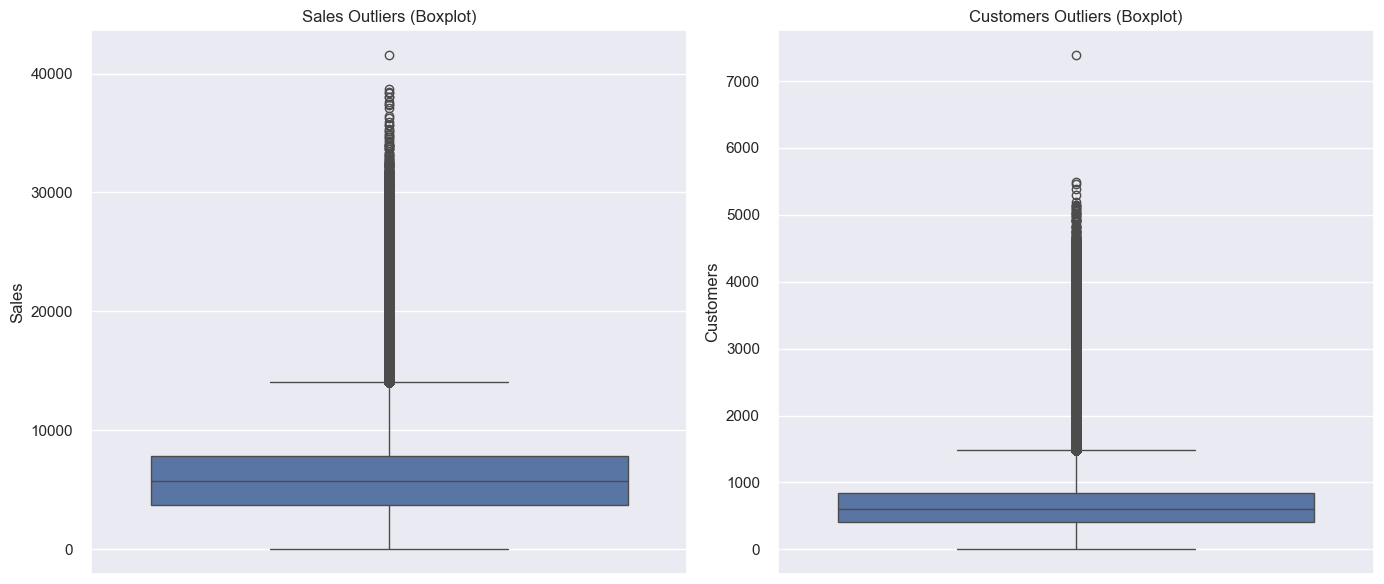

In [5]:
# Step 3: Outlier Analysis


def detect_outliers_iqr(series):
    """Return lower bound, upper bound, and boolean mask for outliers using IQR."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (series < lower) | (series > upper)
    return lower, upper, mask


# Analyze Sales
sales_lower, sales_upper, sales_outliers = detect_outliers_iqr(train["Sales"])

print("Sales outlier thresholds:")
print("Lower bound:", sales_lower)
print("Upper bound:", sales_upper)
print("Outlier count:", sales_outliers.sum())
print("Outlier percentage:", round(sales_outliers.mean() * 100, 2), "%")

# Analyze Customers
cust_lower, cust_upper, cust_outliers = detect_outliers_iqr(train["Customers"])

print("\nCustomers outlier thresholds:")
print("Lower bound:", cust_lower)
print("Upper bound:", cust_upper)
print("Outlier count:", cust_outliers.sum())
print("Outlier percentage:", round(cust_outliers.mean() * 100, 2), "%")

# Boxplots to visualize distributions and outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=train, y="Sales", ax=axes[0])
axes[0].set_title("Sales Outliers (Boxplot)")

sns.boxplot(data=train, y="Customers", ax=axes[1])
axes[1].set_title("Customers Outliers (Boxplot)")

plt.tight_layout()
plt.show()

In [6]:
# Step 4: Time-based EDA

# Ensure Date column is datetime (safety)
train["Date"] = pd.to_datetime(train["Date"])

# Extract time features
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["Day"] = train["Date"].dt.day
train["WeekOfYear"] = train["Date"].dt.isocalendar().week
train["DayOfWeek"] = train["Date"].dt.dayofweek  # 0=Mon, 6=Sun

print("Extracted time features: Year, Month, Day, WeekOfYear, DayOfWeek")

train[["Date", "Year", "Month", "Day", "WeekOfYear", "DayOfWeek"]].head()

Extracted time features: Year, Month, Day, WeekOfYear, DayOfWeek


,Date,Year,Month,Day,WeekOfYear,DayOfWeek
0,2015-07-31,2015,7,31,31,4
1,2015-07-31,2015,7,31,31,4
2,2015-07-31,2015,7,31,31,4
3,2015-07-31,2015,7,31,31,4
4,2015-07-31,2015,7,31,31,4


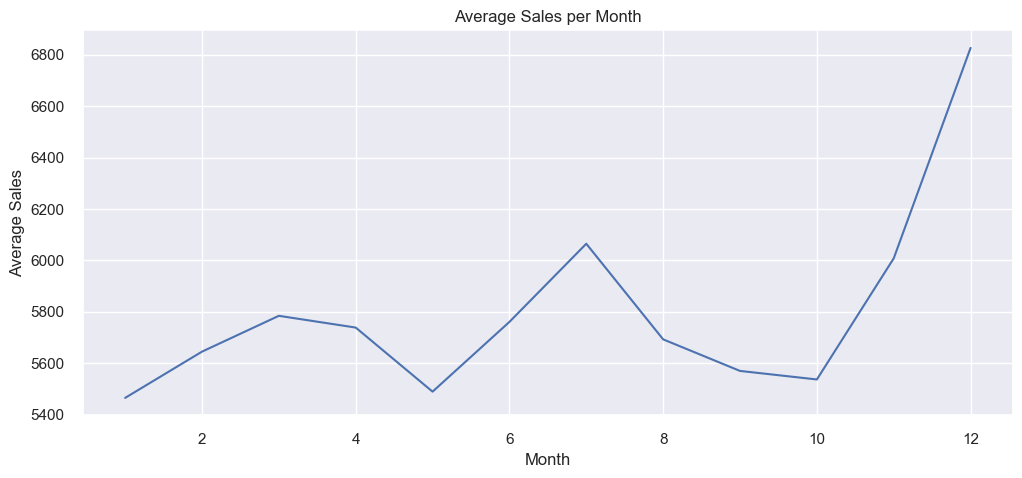

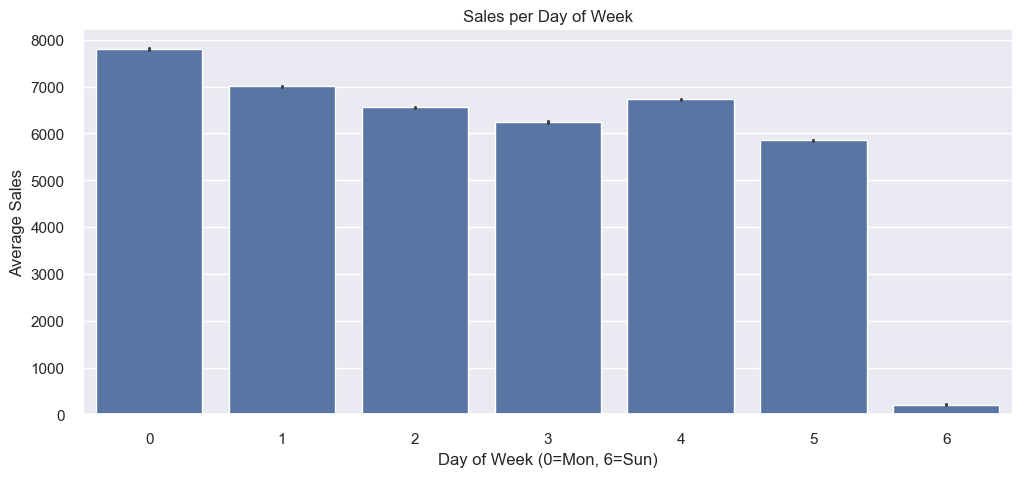

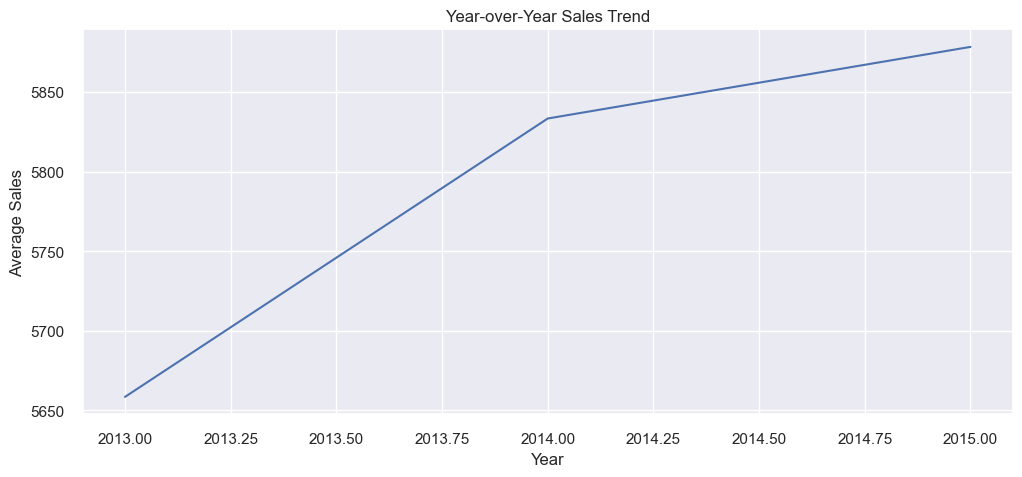

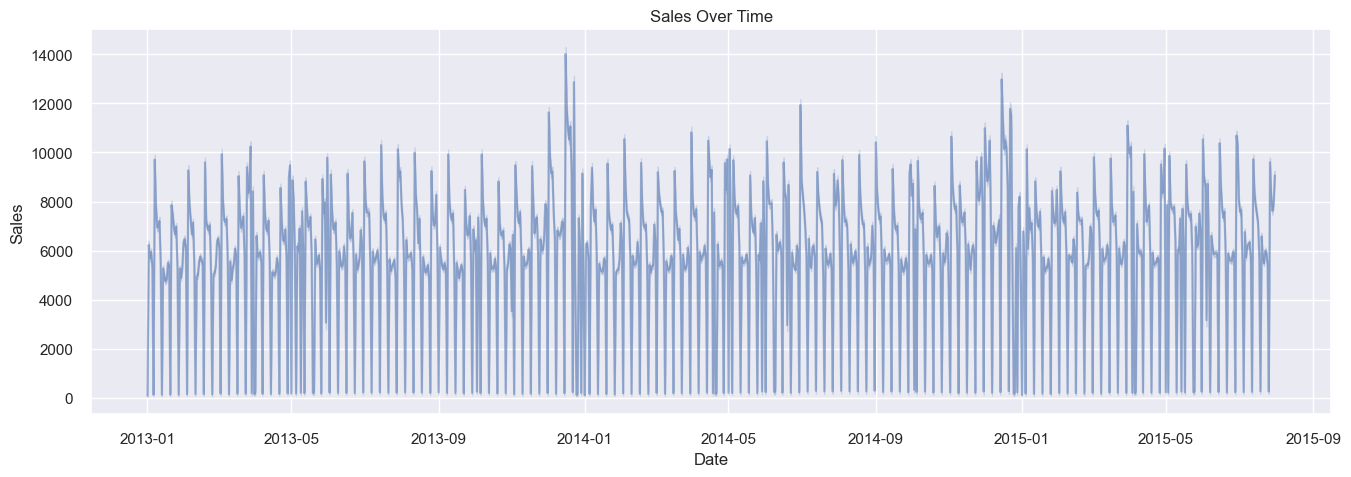

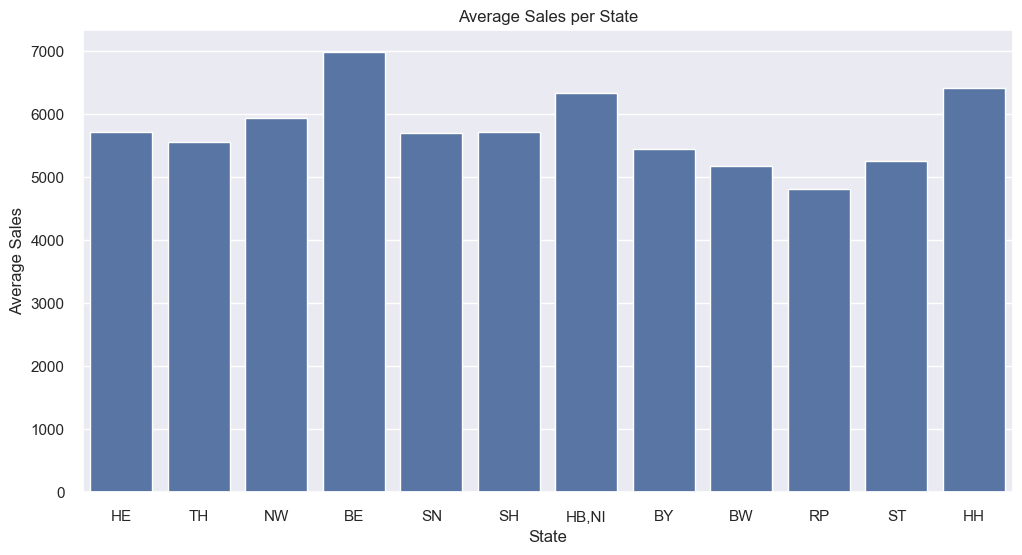

In [7]:
# Visualize time patterns

# Sales per Month
plt.figure(figsize=(12, 5))
sns.lineplot(data=train.groupby("Month")["Sales"].mean())
plt.title("Average Sales per Month")
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.grid(True)
plt.show()

# Sales per Day of Week
plt.figure(figsize=(12, 5))
sns.barplot(x="DayOfWeek", y="Sales", data=train)
plt.title("Sales per Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Average Sales")
plt.show()

# Sales Trend: Year over Year
plt.figure(figsize=(12, 5))
sns.lineplot(data=train.groupby("Year")["Sales"].mean())
plt.title("Year-over-Year Sales Trend")
plt.ylabel("Average Sales")
plt.xlabel("Year")
plt.grid(True)
plt.show()

# Sales over Time (full timeseries)
plt.figure(figsize=(16, 5))
sns.lineplot(data=train, x="Date", y="Sales", alpha=0.5)
plt.title("Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

# Average Sales per State
plt.figure(figsize=(12, 6))
sns.barplot(
    data=train,
    x="State",
    y="Sales",
    estimator="mean",
    errorbar=None
)
plt.title("Average Sales per State")
plt.xlabel("State")
plt.ylabel("Average Sales")
plt.show()

In [8]:
# Step 5: Outlier Treatment - clipping using 1st and 99th percentiles

def clip_percentile(series, lower_q=0.01, upper_q=0.99):
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    return series.clip(lower, upper)


train_clipped_p99 = train.copy()

for col in numeric_cols:
    train_clipped_p99[col] = clip_percentile(train_clipped_p99[col])

print("Applied percentile-based clipping (1 percent to 99 percent).")

Applied percentile-based clipping (1 percent to 99 percent).


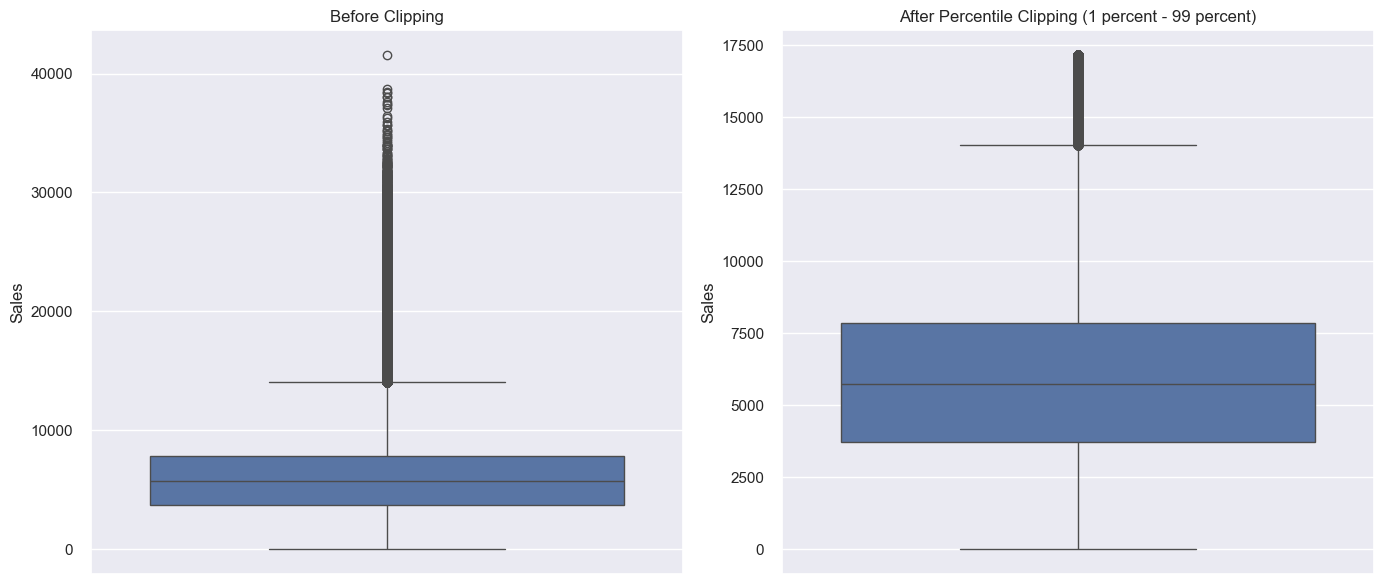

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=train, y="Sales", ax=axes[0])
axes[0].set_title("Before Clipping")

sns.boxplot(data=train_clipped_p99, y="Sales", ax=axes[1])
axes[1].set_title("After Percentile Clipping (1 percent - 99 percent)")

plt.tight_layout()
plt.show()

In [48]:
# Step 6: Advanced visualizations with geo and state features

import plotly.express as px

# Interactive Geo Map: Average Sales by State

state_geo = (
    train_clipped_p99.groupby("State")
    .agg({
        "LatMean": "mean",
        "LonMean": "mean",
        "Sales": "mean",
    })
    .reset_index()
)

fig = px.scatter_map(
    state_geo,
    lat="LatMean",
    lon="LonMean",
    size="Sales",
    color="Sales",
    hover_name="State",
    color_continuous_scale="Rainbow_r",
    zoom=4,
    height=600,
    title="Average Sales by State (Interactive Geo Map)"
)

fig.show()

In [41]:
import plotly.express as px

# Load raw geo dataset directly for store-level plotting
geo_path = DATA_PROCESSED.parent / "rossmann_store_geo.csv"
df_geo = pd.read_csv(geo_path, encoding="latin1")

fig = px.scatter_map(
    df_geo,
    lat="lat",
    lon="lon",
    color="State",
    hover_name="city",
    hover_data=["population", "elevation", "opened_sunday"],
    zoom=5,
    height=800,
    title="All Store Locations (Interactive Geo Map)"
)

fig.show()

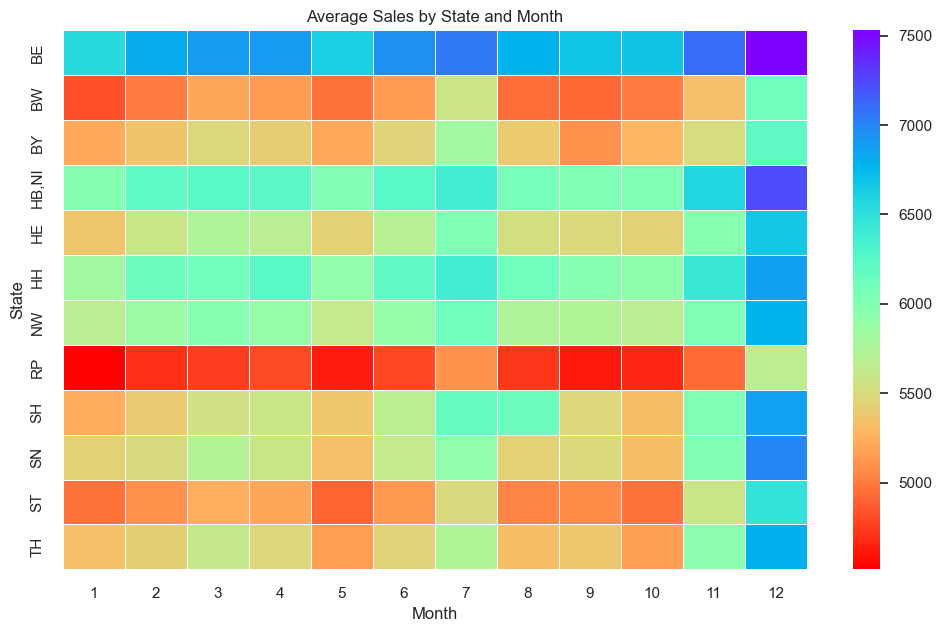

In [45]:
# Heatmap: Average Sales by State and Month

# Ensure Month exists (in case kernel was restarted or data reloaded)
train_clipped_p99["Date"] = pd.to_datetime(train_clipped_p99["Date"])
train_clipped_p99["Month"] = train_clipped_p99["Date"].dt.month

pivot_state_month = train_clipped_p99.pivot_table(
    values="Sales",
    index="State",
    columns="Month",
    aggfunc="mean"
)

plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot_state_month,
    cmap="rainbow_r",
    linewidths=0.5
)
plt.title("Average Sales by State and Month")
plt.xlabel("Month")
plt.ylabel("State")
plt.show()

In [50]:
import plotly.express as px

# Aggregate total sales per state
state_sales = (
    train_clipped_p99.groupby("State")["Sales"]
    .sum()
    .reset_index()
    .sort_values("Sales", ascending=False)
)

fig = px.bar(
    state_sales,
    x="State",
    y="Sales",
    title="Total Sales by State",
    color="Sales",
    color_continuous_scale="Rainbow_r",
)
fig.update_layout(height=600, xaxis_tickangle=-45)
fig.show()